In [38]:
import csv
import random
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

from sklearn import metrics
from metric_learn import LMNN
from metric_learn import NCA
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# 3D scatter plot
import pylab
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline  

In [39]:
def confusionMatrixFromRandomClusters(truth, prediction):
    if len(truth) != len(prediction):
        raise ValueError("Truth labels and prediction labels must have same length")
    
    truthLength = len(set(truth))
    predictionLength = len(set(prediction))
    
    M = np.zeros(shape=(truthLength,predictionLength))
    for i in range(len(truth)):
        M[truth[i]][prediction[i]] += 1
    
    # rename (reorder) clusters so that it matches predictions (heuristic: sort by largest )
    perm = np.argmax(M, axis=1)
    permAll = list(range(predictionLength))
    result = [i for i in permAll if not i in set(perm) ]
    permOrdered = np.concatenate((perm, result)).astype(int)
    
    # return matrix with clusters ordered/renamed
    return (M[:, permOrdered], renameLabels(prediction, permOrdered))

def renameLabels(labels, permutation):
    ordering = np.argsort(permutation)
    # negative prediction can be returned by DBSCAN
    return [x if x < 0 else ordering[x] for x in labels]

def sizesFunction(x, truth, numberOfClusters):
    if x == truth:
        return 25 # correct cluster/label
    elif 0 <= x <= numberOfClusters:
        return 200 # incorrect cluster/label
    else:
        return 100 # new cluster

def sizesForMislabeledData(data, truth, numberOfClusters = -1):
    if numberOfClusters == -1:
        numberOfClusters = max(truth)
    return [sizesFunction(x,t,numberOfClusters) for x,t in zip(data, truth)]

In [40]:
def MahalanobisDist(x, y):
    covariance_xy = np.cov(x,y, rowvar=0)
    inv_covariance_xy = np.linalg.inv(covariance_xy)
    xy_mean = np.mean(x),np.mean(y)
    x_diff = np.array([x_i - xy_mean[0] for x_i in x])
    y_diff = np.array([y_i - xy_mean[1] for y_i in y])
    diff_xy = np.transpose([x_diff, y_diff])
    print(diff_xy)
    
    md = []
    for i in range(len(diff_xy)):
        md.append(np.sqrt(np.dot(np.dot(np.transpose(diff_xy[i]),inv_covariance_xy),diff_xy[i])))
    return md

In [41]:
def randnClusters(M):
    ret = []
    for cluster in M:
        N = cluster[0]
        dim = len(cluster)-1
        data = np.random.randn(N, dim)
        
        for d in range(dim):
            data[:,d] = cluster[1+d][0] * data[:,d] + cluster[1+d][1]
        
        if len(ret) == 0:
            ret = data
        else:
            ret = np.vstack([ret, data])
            
    return ret 

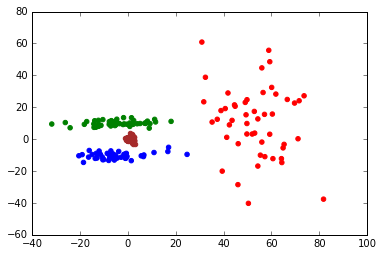

In [42]:
pars = [
    [50, (10,50), (20,10)],
    [50, (10,-5), (2,-10)],
    [50, (10,-5), (2,10)],
]

genClusters = randnClusters(pars)
x,y = genClusters[:,0],genClusters[:,1]
plt.scatter(x,y, color=((['r']*50)+(['b']*50)+(['g']*50)))

covariance_xy = np.cov(x,y, rowvar=0)
A = np.linalg.inv(covariance_xy)
A12 = la.sqrtm(A)

#scaled = ([ np.dot(A12, i) for i in genClusters ])
scaled = np.transpose(np.dot(A12, np.transpose(genClusters)))

#    3 5 7
#    4 6 8
#1 2
#3 4

plt.scatter(scaled[:,0], scaled[:,1], color='brown')
plt.show()

In [43]:
target = ([0]*50)+([1]*50)+([2]*50)

lmnn = LMNN(k=10)
lmnn.fit(genClusters, target, verbose=False)

[[ 0.04630966 -0.00334283]
 [-0.00311813  0.06574107]]


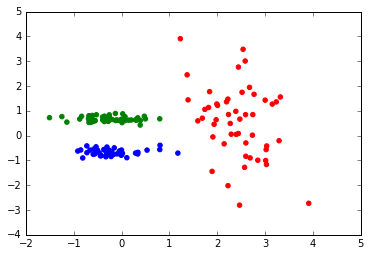

In [44]:
tra = lmnn.transform(genClusters)

#L12 = la.sqrtm(lmnn.L)
#scaled = ([ np.dot(A12, i) for i in genClusters ])
#tra = np.transpose(np.dot(L12, np.transpose(genClusters)))
print(lmnn.L)

plt.scatter(tra[:,0], tra[:,1], color=((['r']*50)+(['b']*50)+(['g']*50)))

1 7962.65 -inf 24073 1e-06
2 7866.96772185 -95.6822781487 23678 1.0099999999999999e-06
3 7775.39933339 -91.5683884587 23350 1.0200999999999998e-06
4 7687.14189373 -88.2574396659 23036 1.0303009999999997e-06
5 7601.99276515 -85.1491285793 22747 1.0406040099999998e-06
6 7519.6419792 -82.350785952 22446 1.0510100500999999e-06
7 7440.12139526 -79.5205839319 22174 1.061520150601e-06
8 7363.1305595 -76.9908357663 21905 1.07213535210701e-06
9 7288.60270462 -74.5278548758 21593 1.08285670562808e-06
10 7216.86058065 -71.7421239712 21363 1.0936852726843608e-06
11 7146.94699607 -69.9135845802 21135 1.1046221254112045e-06
12 7078.97104716 -67.9759489105 20906 1.1156683466653166e-06
13 7012.91710281 -66.0539443538 20701 1.1268250301319698e-06
14 6948.33988439 -64.5772184199 20484 1.1380932804332895e-06
15 6885.51041447 -62.8294699166 20246 1.1494742132376223e-06
16 6824.76213699 -60.7482774756 20013 1.1609689553699985e-06
17 6765.8449083 -58.9172286984 19823 1.1725786449236986e-06
18 6708.31560592 

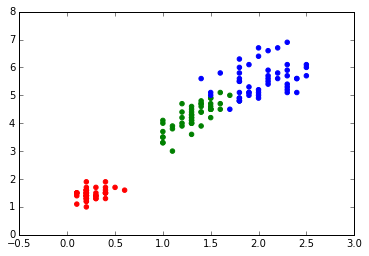

In [9]:
iris_data = load_iris()
X = iris_data['data']
Y = iris_data['target']

#print(X,Y)

Ycolors = [ "r" if x==0 else "g" if x==1 else "b" for x in Y]

plt.scatter(X[:,3],X[:,2],color=Ycolors)

lmnn = LMNN(k=20, learn_rate=1e-6)
nca = NCA()
lmnn.fit(X, Y, verbose=True)
nca.fit(X, Y)
print(lmnn.L)
print(lmnn.metric())
print(nca.metric())

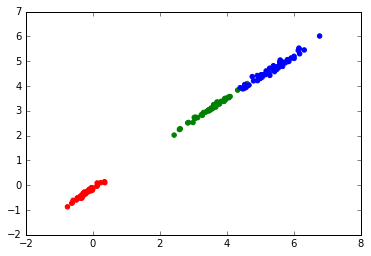

In [86]:
Xt = lmnn.transform(X)
Xtnca = nca.transform(X)

plt.scatter(Xt[:,3],Xt[:,2],color=Ycolors)
plt.show()

In [2]:
#%matplotlib qt 

neigh = KMeans(n_clusters=3)
neigh.fit(X) 

contTable, predictedLabels = confusionMatrixFromRandomClusters(Y, neigh.labels_)

colors = ["green", "blue", "yellow", "purple", "pink"]
YpredColors = [ colors[x] for x in predictedLabels]
YpredColors = [ x[0] if x[1]==x[2] else "r" for x in zip(YpredColors, Y, predictedLabels)]

ax = Axes3D(pylab.figure())
ax.scatter(X[:,1],X[:,2],X[:,3],s=sizesForMislabeledData(predictedLabels, Y),c=YpredColors)
#plt.scatter(X[:,3],X[:,2],color=YpredColors)

score = metrics.adjusted_rand_score(Y, neigh.labels_)
print(score)
print(contTable)

NameError: name 'KMeans' is not defined

0.9410122562924206
[[ 50.   0.   0.]
 [  0.  48.   2.]
 [  0.   1.  49.]]


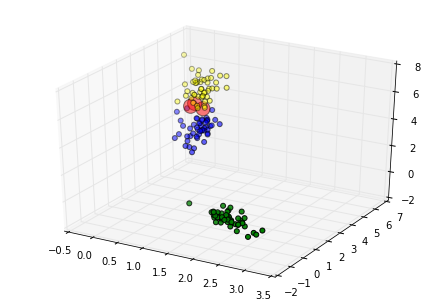

In [88]:
neigh = KMeans(n_clusters=3)
neigh.fit(Xt) 

contTable, predictedLabels = confusionMatrixFromRandomClusters(Y, neigh.labels_)

colors = ["green", "blue", "yellow", "purple", "pink"]
YpredColors = [ colors[x] for x in predictedLabels]
YpredColors = [ x[0] if x[1]==x[2] else "r" for x in zip(YpredColors, Y, predictedLabels)]

ax = Axes3D(pylab.figure())
ax.scatter(Xt[:,1],Xt[:,2],Xt[:,3],s=sizesForMislabeledData(predictedLabels, Y),c=YpredColors)

score = metrics.adjusted_rand_score(Y, neigh.labels_)
print(score)
print(contTable)

0.6841081459139292
[[ 47.   0.   0.   0.   3.]
 [  0.  38.   3.   4.   5.]
 [  0.   0.  33.   0.  17.]]


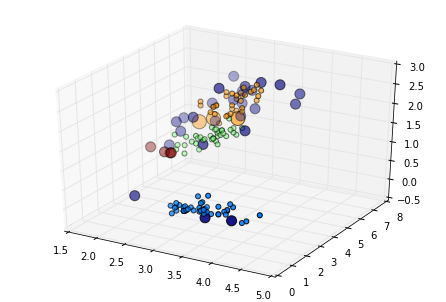

In [89]:
neigh = DBSCAN(eps=0.4, min_samples=4)
neigh.fit(X) 

contTable, predictedLabels = confusionMatrixFromRandomClusters(Y, neigh.labels_)

ax = Axes3D(pylab.figure())
ax.scatter(X[:,1],X[:,2],X[:,3],s=sizesForMislabeledData(predictedLabels, Y),c=predictedLabels)

score = metrics.adjusted_rand_score(Y, neigh.labels_)
print(score)
print(contTable)

0.878669359800144
[[ 50.   0.   0.   0.]
 [  0.  46.   4.   0.]
 [  0.   0.  45.   5.]]


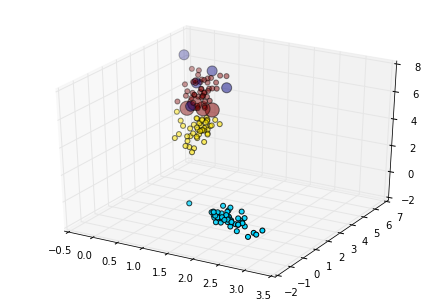

In [94]:
neigh = DBSCAN(eps=0.55, min_samples=4)
neigh.fit(Xt) 

contTable, predictedLabels = confusionMatrixFromRandomClusters(Y, neigh.labels_)

ax = Axes3D(pylab.figure())
ax.scatter(Xt[:,1],Xt[:,2],Xt[:,3],s=sizesForMislabeledData(predictedLabels, Y),c=neigh.labels_)

score = metrics.adjusted_rand_score(Y, neigh.labels_)
print(score)
print(contTable)

0.878669359800144
[[ 50.   0.   0.   0.]
 [  0.  46.   4.   0.]
 [  0.   0.  45.   5.]]


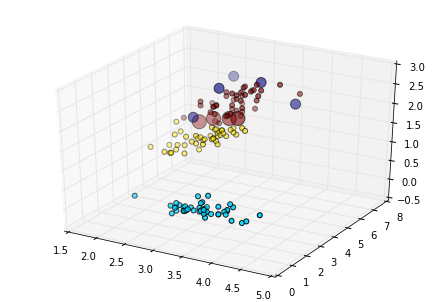

In [96]:
neigh = DBSCAN(eps=0.55, min_samples=4, metric=lambda X,Y:metrics.pairwise.pairwise_distances(X,Y,metric='mahalanobis',VI=lmnn.metric()))
neigh.fit(X)

contTable, predictedLabels = confusionMatrixFromRandomClusters(Y, neigh.labels_)

ax = Axes3D(pylab.figure())
ax.scatter(X[:,1],X[:,2],X[:,3],s=sizesForMislabeledData(predictedLabels, Y),c=neigh.labels_)

score = metrics.adjusted_rand_score(Y, neigh.labels_)
print(score)
print(contTable)